# Проект - Информационная безопасность

## Описание проекта

Компания онлайн-сервис с высоким уровнем входящего трафика имеет специализированный отдел безопасности, который занимается фильтрацией и анализом трафика. Сотрудники этого отдела обратились за помощью в автоматизации выявления аномального и злонамеренного трафика. Ваша задача - разработать модель, которая будет классифицировать трафик на нормальный и злонамеренный, включая следующие типы атак: DDoS, SQL-инъекции, брутфорс, вредоносные программы и т.д.

В ходе работы вы пройдете все основные этапы полноценного исследования:\
🔸 загрузка и ознакомление с данными,\
🔸 предварительная обработка,\
🔸 полноценный разведочный анализ,\
🔸 разработка новых синтетических признаков,\
🔸 проверка на мультиколлинеарность,\
🔸 отбор финального набора обучающих признаков,\
🔸 выбор и обучение моделей,\
🔸 итоговая оценка качества предсказания лучшей модели,\
🔸 анализ важности ее признаков.

### Задача

🔸 Разработать модель, которая будет классифицировать трафик на нормальный и злонамеренный. При этом модель должна работать максимально качественно, так как цена ошибки может быть очень высока.\
🔸 Оценить качество модели по различным метрикам классификации: precision, recall, f1_score, accuracy.\
🔸 (*) Деплой: разработать REST API сервис, который будет принимать на вход данные трафика и возвращать класс этого трафика.\

### Этапы работы:

🔸 Вводный вебинар, постановка задачи\
🔸 Самостоятельная работа, проведение Stand-up, обсуждение результатов в канале\
🔸 Демонстрация результатов проекта

### Исходные данные

🔸 Ссылка на датасет - https://disk.yandex.ru/d/QYraoEwmfQZ90Q

### План работы

**1. Знакомство с данными**

    1.1 Импорт библиотек
    
    1.2 Загрузка данных
    
    1.3 Исследовательский анализ данных (размер, признаки, строки, типы данных, пропуски, аномалии, дубликаты, кореляция, распределение)
    
 **2. Предобработка данных**
    
    2.1 Преобразование типов данных 
    
    2.2 Разбиение на выборки
    
    2.3 Нормализация значений
    
 **3. Обучение моделей**
 
 
 **4. Вывод**
 
 **5. Отчет**

# Установка библиотек и загрузка данных

In [1]:
#%pip install -r requirements.txt

In [2]:
import re
import warnings

from catboost import CatBoostClassifier
from catboost.utils import eval_metric

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.tree import DecisionTreeClassifier

import sweetviz as sv

from xgboost import XGBClassifier
# settings for pandas
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200
pd.options.display.float_format = '{:.2f}'.format
#pd.options.mode.chained_assignment = None

# warnings
warnings.filterwarnings("ignore")
#warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
TEST_SIZE = 0.2
RANDOM_STATE = 42

In [4]:
df = pd.read_csv('data\\network_traffic_data.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539616 entries, 0 to 539615
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             539616 non-null  int64  
 1    Flow Duration                539616 non-null  int64  
 2    Total Fwd Packets            539616 non-null  int64  
 3    Total Backward Packets       539616 non-null  int64  
 4   Total Length of Fwd Packets   539616 non-null  int64  
 5    Total Length of Bwd Packets  539616 non-null  int64  
 6    Fwd Packet Length Max        539616 non-null  int64  
 7    Fwd Packet Length Min        539616 non-null  int64  
 8    Fwd Packet Length Mean       539616 non-null  float64
 9    Fwd Packet Length Std        539616 non-null  float64
 10  Bwd Packet Length Max         539616 non-null  int64  
 11   Bwd Packet Length Min        539616 non-null  int64  
 12   Bwd Packet Length Mean       539616 non-nul

79 столбцов по 539616 значений. Целевой признак Label.Явных пропусков нет. Типы данных соответствуют ожидаемым.

В данных есть столбцы с min max mean std возможно дополнительно генерировать признаки не потребуется

In [6]:
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,5480074,3,1,12,0,6,0,4.00,3.46,0,0,0.00,0.00,2.19,0.73,1826691.40,3131700.20,5442804,101,5480074,2740037.00,3822289.80,5442804,37270,0,0.00,0.00,0,0,0,0,0,0,72,32,0.55,0.18,0,6,2.40,3.29,10.80,0,0,0,1,0,0,0,0,0,3.00,4.00,0.00,72,0,0,0,0,0,0,3,12,1,0,8192,42780,2,20,0.00,0.00,0,0,0.00,0.00,0,0,BENIGN
1,443,711977,9,10,703,3950,267,0,78.10,103.30,1448,0,395.00,587.50,6535.32,26.69,39554.28,50154.62,120501,1,616301,77037.62,72995.98,215614,230,616874,68541.55,71985.97,199836,1,0,0,0,0,296,328,12.64,14.05,0,1448,232.60,442.80,196012.66,0,0,0,1,0,0,0,0,1,244.90,78.10,395.00,296,0,0,0,0,0,0,9,703,10,3950,29200,252,4,32,0.00,0.00,0,0,0.00,0.00,0,0,BENIGN
2,53,153398,2,2,80,224,40,40,40.00,0.00,112,112,112.00,0.00,1981.77,26.08,51132.67,88558.31,153391,3,3,3.00,0.00,3,3,4,4.00,0.00,4,4,0,0,0,0,40,40,13.04,13.04,40,112,68.80,39.44,1555.20,0,0,0,0,0,0,0,0,1,86.00,40.00,112.00,40,0,0,0,0,0,0,2,80,2,224,-1,-1,1,20,0.00,0.00,0,0,0.00,0.00,0,0,BENIGN
3,53,57660,1,1,46,128,46,46,46.00,0.00,128,128,128.00,0.00,3017.69,34.69,57660.00,0.00,57660,57660,0,0.00,0.00,0,0,0,0.00,0.00,0,0,0,0,0,0,20,20,17.34,17.34,46,128,73.30,47.34,2241.33,0,0,0,0,0,0,0,0,1,110.00,46.00,128.00,20,0,0,0,0,0,0,1,46,1,128,-1,-1,0,20,0.00,0.00,0,0,0.00,0.00,0,0,BENIGN
4,8446,767,3,1,43,6,31,6,14.34,14.44,6,6,6.00,0.00,63885.27,5215.12,255.67,394.29,710,3,713,356.50,499.92,710,3,0,0.00,0.00,0,0,0,0,0,0,60,20,3911.34,1303.78,6,31,11.00,11.18,125.00,0,0,0,0,1,0,0,0,0,13.75,14.34,6.00,60,0,0,0,0,0,0,3,43,1,6,1017,0,2,20,0.00,0.00,0,0,0.00,0.00,0,0,BENIGN


In [7]:
df.describe(include='all')

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
count,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539128.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BENIGN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,240000
mean,5563.06,21066929.37,6.12,5.99,408.24,7999.78,169.45,11.86,44.68,59.53,1675.07,23.51,550.04,697.31,inf,inf,2134902.45,5264534.55,17318403.50,294558.36,20756340.18,4036797.30,6666492.26,17200410.93,1035760.29,9601754.01,2028745.22,2413091.18,6464188.15,814778.83,0.04,0.00,0.00,0.00,-4593.96,-4290.45,71421.49,7885.31,9.61,1723.70,276.58,544.09,1112687.62,0.06,0.04,0.00,0.38,0.37,0.06,0.00,0.00,0.64,305.36,44.68,550.04,-4593.96,0.00,0.00,0.00,0.00,0.00,0.00,6.12,408.24,5.99,7998.77,7564.76,1277.94,2.95,-2429.31,115498.42,40375.70,167288.24,89830.17,16101546.63,958564.89,16872266.93,15391495.53,NaN
std,14921.26,38121719.63,345.11,463.49,7478.35,1014441.80,560.53,60.96,150.87,217.73,2843.53,55.20,869.70,1255.31,NaN,NaN,5824584.75,10551103.82,33957014.03,4269410.12,38121061.80,10627587.74,13914086.55,34021535.79,8949950.83,28072181.79,9045625.35,8975672.92,21921965.46,7698886.82,0.19,0.00,0.01,0.00,2095355.38,207661

In [8]:
#df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [9]:
new_col_names = []
for column in df.columns:
    new_col_names.append(column.strip().replace(' ', '_').lower())

df.columns = new_col_names

EDA проведем с помощью библиотеки SweetViz

In [10]:
#report = sv.analyze(df)
#report.show_html('common analysis.html')

## destination_port

Порт назначения - порт на который отправляется пакет. 

In [11]:
df['destination_port'].describe()

count   539616.00
mean      5563.06
std      14921.26
min          0.00
25%         80.00
50%         80.00
75%        443.00
max      65533.00
Name: destination_port, dtype: float64

Официально порт 0 не существует, и к нему нельзя подключиться. Однако можно отправлять интернет-пакет на порт 0

In [12]:
df['destination_port'].value_counts().head(10)

destination_port
80      229165
53      101315
443      53430
21        8638
22        7245
123       2412
8080      1488
137        810
389        760
88         630
Name: count, dtype: int64

In [13]:
set(df.query('label != "BENIGN"')['destination_port'].value_counts().head(5))

{158, 1346, 6037, 8067, 204285}

Обычные порты используемые в сетях. Возможно частота некоторых интуитвно не должна быть такой высокой, но назначение сети мы не знаем.

Из топ портов для атак выпадает 53 порт, зарезервированный для использования с DNS-серверами. Также в топ попадают следующие порты

In [14]:
set(df.query('label != "BENIGN"')['destination_port'].value_counts().head(10).index) - \
set(df['destination_port'].value_counts().head(10).index)

{23, 139, 444, 5432, 6779}

23 - Telnet (протокол удаленного терминала)\
139 - Порт 139 используется для общего доступа к файлам и принтерам, это единственный наиболее опасный порт потому, что оставляет жесткий диск пользователя незащищенным\
444 - SNMP протокол для управления устройствами в IP-сетях(маршрутизаторы, коммутаторы, серверы, рабочие станции, принтеры, модемные стойки и другие)\
5432 - PostgreSQL database\
6779 - обычный tcp/udp

Порт будем обрабатывать как категориальную переменную

In [15]:
df.columns

Index(['destination_port', 'flow_duration', 'total_fwd_packets',
       'total_backward_packets', 'total_length_of_fwd_packets',
       'total_length_of_bwd_packets', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'fwd_packet_length_mean',
       'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_mean',
       'bwd_packet_length_std', 'flow_bytes/s', 'flow_packets/s',
       'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min',
       'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max',
       'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std',
       'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags',
       'fwd_urg_flags', 'bwd_urg_flags', 'fwd_header_length',
       'bwd_header_length', 'fwd_packets/s', 'bwd_packets/s',
       'min_packet_length', 'max_packet_length', 'packet_length_mean',
       'packet_length_std', 'packet_length_variance', 'fin_flag_count',
       'syn_flag_co

**Описание столбцов:**\
`destination_port` - Порт назначения указывает на конечный порт, к которому отправляются пакеты или установлено соединение.\
`flow_duration` - Продолжительность потока отражает время в миллисекундах, которое затратилось на передачу потока.\
`total_fwd_packets` - Общее количество прямых пакетов - это сумма всех пакетов, передаваемых в прямом направлении.\
`total_backward_packets` - Общее количество обратных пакетов - это сумма всех пакетов, передаваемых в обратном направлении.\
`total_length_of_fwd_packets` - Общая длина прямых пакетов показывает общую длину в байтах всех пакетов, передаваемых в прямом направлении.\
`total_length_of_bwd_packets` - Общая длина обратных пакетов показывает общую длину в байтах всех пакетов, передаваемых в обратном направлении.\
`fwd_packet_length_max` - Максимальная длина прямого пакета - это наибольшая длина в байтах среди всех прямых пакетов.\
`fwd_packet_length_min` - Минимальная длина прямого пакета - это наименьшая длина в байтах среди всех прямых пакетов.\
`fwd_packet_length_mean` - Средняя длина прямого пакета - это среднее значение длин в байтах среди всех прямых пакетов.\
`fwd_packet_length_std` - Стандартное отклонение длины прямого пакета - это мера разброса значений длин прямых пакетов относительно их среднего значения.\
`bwd_packet_length_max` - Максимальная длина обратного пакета - это наибольшая длина в байтах среди всех обратных пакетов.\
`bwd_packet_length_min` - Минимальная длина обратного пакета - это наименьшая длина в байтах среди всех обратных пакетов.\
`bwd_packet_length_mean` - Средняя длина обратного пакета - это среднее значение длин в байтах среди всех обратных пакетов.\
`bwd_packet_length_std` - Стандартное отклонение длин обратных пакетов указывает на разброс значений длин обратных пакетов относительно их среднего значения.\
`flow_bytes/s` - Байты потока в секунду показывают сколько байтов передается в сети за одну секунду.\
`flow_packets/s` - Пакеты потока в секунду показывают сколько пакетов передается в сети за одну секунду.\
`flow_iat_mean` - Среднее значение интервала между пакетами потока отражает среднее время, затраченное на передачу пакетов потока.\
`flow_iat_std` - Стандартное отклонение интервала между пакетами потока является мерой разброса значений интервалов между пакетами потока относительно их среднего значения.\
`flow_iat_max` - Наибольший интервал между пакетами потока показывает максимальное время между прибытием пакетов потока.\
`flow_iat_min` - Наименьший интервал между пакетами потока показывает минимальное время между прибытием пакетов потока.\
`fwd_iat_total`- Общий интервал между прямыми пакетами обозначает суммарное время между отправкой прямых пакетов.\
`fwd_iat_mean` - Средний интервал между прямыми пакетами показывает среднее время между отправкой прямых пакетов.\
`fwd_iat_std` - Стандартное отклонение интервала между прямыми пакетами является мерой разброса значений интервалов между прямыми пакетами относительно их среднего значения.\
`fwd_iat_max` - Наибольший интервал между прямыми пакетами показывает максимальное время между отправкой прямых пакетов.\
`fwd_iat_min` - Наименьший интервал между прямыми пакетами показывает минимальное время между отправкой прямых пакетов.\
`bwd_iat_total` - Общий интервал между обратными пакетами обозначает суммарное время между отправкой обратных пакетов.\
`bwd_iat_mean` - Средний интервал между обратными пакетами показывает среднее время между отправкой обратных пакетов.\
`bwd_iat_std` - Стандартное отклонение интервала между обратными пакетами является мерой разброса значений интервалов между обратными пакетами относительно их среднего значения.\
`bwd_iat_max` - Наибольший интервал между обратными пакетами показывает максимальное время между отправкой обратных пакетов.\
`bwd_iat_min` - Наименьший интервал между обратными пакетами показывает минимальное время между отправкой обратных пакетов.\
`fwd_psh_flags` - Флаги Push прямых пакетов обозначают пакеты, которые требуют моментальной передачи данных на приемную сторону без буферизации.\
`bwd_psh_flags` - Флаги Push обратных пакетов обозначают пакеты, которые требуют моментальной передачи данных на отправную сторону без буферизации.\
`fwd_urg_flags` - Флаги Urgent прямых пакетов обозначают пакеты, которые имеют высокий приоритет и требуют немедленной обработки.\
`bwd_urg_flags` - Флаги Urgent обратных пакетов обозначают пакеты, которые имеют высокий приоритет и требуют немедленной обработки.\
`fwd_header_length` - Длина заголовков прямых пакетов показывает размер заголовков прямых пакетов в байтах.\
`bwd_header_length` - Длина заголовков обратных пакетов показывает размер заголовков обратных пакетов в байтах.\
`fwd_packets/s` - Прямые пакеты в секунду показывают сколько прямых пакетов передается в сети за одну секунду.\
`bwd_packets/s` - Обратные пакеты в секунду показывают сколько обратных пакетов передается в сети за одну секунду.\
`min_packet_length` - Минимальная длина пакета указывает на наименьшую длину пакета в байтах.\
`max_packet_length` - Максимальная длина пакета указывает на наибольшую длину пакета в байтах.\
`packet_length_mean` - Средняя длина пакета представляет собой среднее значение длин всех пакетов в байтах.\
`packet_length_std` - Стандартное отклонение длины пакета показывает степень изменчивости длин всех пакетов относительно их среднего значения.\
`packet_length_variance` - Дисперсия длины пакета является мерой разброса значений длин пакетов относительно их среднего значения.\
`fin_flag_count` - Количество пакетов с флагом FIN указывает на количество пакетов, в которых установлен флаг FIN.\
`syn_flag_count` - Количество пакетов с флагом SYN указывает на количество пакетов, в которых установлен флаг SYN.\
`rst_flag_count` - Количество пакетов с флагом RST указывает на количество пакетов, в которых установлен флаг RST.\
`psh_flag_count` - Количество пакетов с флагом PSH указывает на количество пакетов, в которых установлен флаг PSH.\
`ack_flag_count` - Количество пакетов с флагом ACK указывает на количество пакетов, в которых установлен флаг ACK.\
`urg_flag_count` - Количество пакетов с флагом URG указывает на количество пакетов, в которых установлен флаг URG.\
`cwe_flag_count` - Количество пакетов с флагом CWE указывает на количество пакетов, в которых установлен флаг CWE.\
`ece_flag_count` - Количество пакетов с флагом ECE указывает на количество пакетов, в которых установлен флаг ECE.\
`down/up_ratio` - Отношение загрузки "скачать/отправить" представляет собой соотношение количества пакетов в сторону загрузки (скачивания) к количеству пакетов в сторону отправки.\
`average_packet_size` - Средний размер пакета указывает на среднюю длину пакета в байтах.\
`avg_fwd_segment_size` - Средний размер прямого сегмента представляет собой среднюю длину прямого сегмента в байтах.\
`avg_bwd_segment_size` - Средний размер обратного сегмента представляет собой среднюю длину обратного сегмента в байтах.\
`fwd_header_length.1` - Длина заголовка прямого пакета указывает на размер заголовка прямого пакета в байтах.\
`fwd_avg_bytes/bulk` - Среднее количество байт в пакете прямого потока представляет собой среднее количество байт в каждом пакете прямого потока.\
`fwd_avg_packets/bulk` - Среднее количество пакетов в прямом потоке представляет собой среднее количество пакетов в каждом прямом потоке.\
`fwd_avg_bulk_rate` - Средняя скорость передачи блоков в прямом направлении указывает на среднюю скорость передачи блоков данных в прямом направлении.\
`bwd_avg_bytes/bulk` - Среднее количество байт в блоке в обратном направлении показывает среднее количество байтов в каждом блоке данных в обратном направлении.\
`bwd_avg_packets/bulk` - Среднее количество пакетов в блоке в обратном направлении показывает среднее количество пакетов в каждом блоке данных в обратном направлении.\
`bwd_avg_bulk_rate` - Средняя скорость передачи блоков в обратном направлении указывает на среднюю скорость передачи блоков данных в обратном направлении.\
`subflow_fwd_packets` - Количество пакетов в подпотоке в прямом направлении показывает количество пакетов, передаваемых в подпотоке в прямом направлении.\
`subflow_fwd_bytes` - Количество байтов в подпотоке в прямом направлении показывает количество байтов, передаваемых в подпотоке в прямом направлении.\
`subflow_bwd_packets` - Количество пакетов в подпотоке в обратном направлении показывает количество пакетов, передаваемых в подпотоке в обратном направлении.\
`subflow_bwd_bytes` - Количество байтов в подпотоке в обратном направлении показывает количество байтов, передаваемых в подпотоке в обратном направлении.\
`init_win_bytes_forward` - Начальный размер окна приема в байтах в прямом направлении указывает на начальный размер окна приема данных в байтах в прямом направлении.\
`init_win_bytes_backward` - Начальный размер окна приема в байтах в обратном направлении указывает на начальный размер окна приема данных в байтах в обратном направлении.\
`act_data_pkt_fwd` - Количество активных прямых пакетов данных показывает количество активных прямых пакетов передачи данных.\
`min_seg_size_forward` - Минимальный размер сегмента в прямом направлении указывает на минимальный размер сегмента данных в прямом направлении.\
`active_mean` - Среднее значение активных соединений показывает среднее количество активных соединений в сети.\
`active_std` - Стандартное отклонение активных соединений указывает на степень изменчивости активных соединений относительно их среднего значения.\
`active_max` - Максимальное количество активных соединений показывает максимальное количество одновременно активных соединений в сети.\
`active_min` - Минимальное количество активных соединений показывает минимальное количество одновременно активных соединений в сети.\
`idle_mean` - Среднее значение простаивающих соединений показывает среднее количество простаивающих соединений в сети.\
`idle_std` - Стандартное отклонение простаивающих соединений указывает на степень изменчивости простаивающих соединений относительно их среднего значения.\
`idle_max` - Максимальное количество простаивающих соединений показывает максимальное количество одновременно простаивающих соединений в сети.\
`idle_min` - Минимальное количество простаивающих соединений показывает минимальное количество одновременно простаивающих соединений в сети.

## flow_duration 

In [16]:
df['flow_duration'].describe()

count      539616.00
mean     21066929.37
std      38121719.63
min           -12.00
25%            73.00
50%         49739.00
75%      10640295.25
max     119999993.00
Name: flow_duration, dtype: float64

Продолжительность передачи, не может быть отрицательной

In [17]:
df[df.select_dtypes(include=[np.number]).ge(0).all(1)]

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,bwd_packet_length_mean,bwd_packet_length_std,flow_bytes/s,flow_packets/s,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_total,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_total,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,bwd_psh_flags,fwd_urg_flags,bwd_urg_flags,fwd_header_length,bwd_header_length,fwd_packets/s,bwd_packets/s,min_packet_length,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,cwe_flag_count,ece_flag_count,down/up_ratio,average_packet_size,avg_fwd_segment_size,avg_bwd_segment_size,fwd_header_length.1,fwd_avg_bytes/bulk,fwd_avg_packets/bulk,fwd_avg_bulk_rate,bwd_avg_bytes/bulk,bwd_avg_packets/bulk,bwd_avg_bulk_rate,subflow_fwd_packets,subflow_fwd_bytes,subflow_bwd_packets,subflow_bwd_bytes,init_win_bytes_forward,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,80,5480074,3,1,12,0,6,0,4.00,3.46,0,0,0.00,0.00,2.19,0.73,1826691.40,3131700.20,5442804,101,5480074,2740037.00,3822289.80,5442804,37270,0,0.00,0.00,0,0,0,0,0,0,72,32,0.55,0.18,0,6,2.40,3.29,10.80,0,0,0,1,0,0,0,0,0,3.00,4.00,0.00,72,0,0,0,0,0,0,3,12,1,0,8192,42780,2,20,0.00,0.00,0,0,0.00,0.00,0,0,BENIGN
1,443,711977,9,10,703,3950,267,0,78.10,103.30,1448,0,395.00,587.50,6535.32,26.69,39554.28,50154.62,120501,1,616301,77037.62,72995.98,215614,230,616874,68541.55,71985.97,199836,1,0,0,0,0,296,328,12.64,14.05,0,1448,232.60,442.80,196012.66,0,0,0,1,0,0,0,0,1,244.90,78.10,395.00,296,0,0,0,0,0,0,9,703,10,3950,29200,252,4,32,0.00,0.00,0,0,0.00,0.00,0,0,BENIGN
4,8446,767,3,1,43,6,31,6,14.34,14.44,6,6,6.00,0.00,63885.27,5215.12,255.67,394.29,710,3,713,356.50,499.92,710,3,0,0.00,0.00,0,0,0,0,0,0,60,20,3911.34,1303.78,6,31,11.00,11.18,125.00,0,0,0,0,1,0,0,0,0,13.75,14.34,6.00,60,0,0,0,0,0,0,3,43,1,6,1017,0,2,20,0.00,0.00,0,0,0.00,0.00,0,0,BENIGN
7,443,65786373,122,191,23544,275883,1093,0,193.00,366.20,4380,0,1444.00,689.00,4551.50,4.76,210853.77,2919396.00,51185854,1,65786373,543689.06,4680394.50,51185854,1,14585289,76764.68,484025.84,4827482,1,0,0,0,0,2464,3832,1.85,2.90,0,4380,953.50,846.00,715368.30,0,0,0,1,0,0,0,0,1,956.50,193.00,1444.00,2464,0,0,0,0,0,0,122,23544,191,275883,65535,75,121,20,14600467.00,0.00,14600467,14600467,51185856.00,0.00,51185854,51185854,BENIGN
8,1877,213,3,1,43,6,31,6,14.34,14.44,6,6,6.00,0.00,230046.95,18779.34,71.00,80.58,164,22,213,106.50,81.32,164,49,0,0.00,0.00,0,0,0,0,0,0,60,20,14084.51,4694.84,6,31,11.00,11.18,125.00,0,0,0,0,1,0,0,0,0,13.75,14.34,6.00,60,0,0,0,0,0,0,3,43,1,6,1311,0,2,20,0.00,0.00,0,0,0.00,0.00,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539611,80,11512204,8,5,326,11632,326,0,40.75,115.25,10184,0,2326.00,4436.00,1038.72,1.13,959350.30,2262615.80,6507197,1,6510770,930110.00,2460477.20,6509948,1,11500000,2878039.50,3378874.20,6507197,196,0,0,0,0,264,168,0.69,0.43,0,10184,854.00,2714.00,7361769.00,0,0,0,1,0,0,0,0,0,920.00,40.75,2326.00,264,0,0,0,0,0,0,8,326,5,11632,29200,235,1,32,892.00,0.00,892,892,6507197.00,0.00,6507197,6507197,DoS GoldenEye
539612,80,11513325,5,5,471,3525,471,0,94.20,210.60,2077,0,705.00,990.50,347.08,0.87,1279258.40,2565152.80,6508582,53,6512631,1628157.80,3255638.80,6511616,176,11500000,2878318.00,3379306.00,6508582,192,0,0,0,0,168,168,0.43,0.43,0,2077,363.20,720.00,518083.62,0,0,0,1,0,0,0,0,1,399.50,9

In [18]:
df[df['flow_duration'] < 0]

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,bwd_packet_length_mean,bwd_packet_length_std,flow_bytes/s,flow_packets/s,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_total,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_total,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,bwd_psh_flags,fwd_urg_flags,bwd_urg_flags,fwd_header_length,bwd_header_length,fwd_packets/s,bwd_packets/s,min_packet_length,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,cwe_flag_count,ece_flag_count,down/up_ratio,average_packet_size,avg_fwd_segment_size,avg_bwd_segment_size,fwd_header_length.1,fwd_avg_bytes/bulk,fwd_avg_packets/bulk,fwd_avg_bulk_rate,bwd_avg_bytes/bulk,bwd_avg_packets/bulk,bwd_avg_bulk_rate,subflow_fwd_packets,subflow_fwd_bytes,subflow_bwd_packets,subflow_bwd_bytes,init_win_bytes_forward,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
6139,443,-1,1,1,6,6,6,6,6.00,0.00,6,6,6.00,0.00,-12000000.00,-2000000.00,-1.00,0.00,-1,-1,0,0.00,0.00,0,0,0,0.00,0.00,0,0,0,0,0,0,20,20,0.00,0.00,6,6,6.00,0.00,0.00,0,0,0,0,1,0,0,0,1,9.00,6.00,6.00,20,0,0,0,0,0,0,1,6,1,6,63846,51100,0,20,0.00,0.00,0,0,0.00,0.00,0,0,BENIGN
10236,80,-1,1,1,6,6,6,6,6.00,0.00,6,6,6.00,0.00,-12000000.00,-2000000.00,-1.00,0.00,-1,-1,0,0.00,0.00,0,0,0,0.00,0.00,0,0,0,0,0,0,20,20,0.00,0.00,6,6,6.00,0.00,0.00,0,0,0,0,1,0,0,0,1,9.00,6.00,6.00,20,0,0,0,0,0,0,1,6,1,6,253,288,0,20,0.00,0.00,0,0,0.00,0.00,0,0,BENIGN
26940,443,-1,1,1,0,0,0,0,0.00,0.00,0,0,0.00,0.00,0.00,-2000000.00,-1.00,0.00,-1,-1,0,0.00,0.00,0,0,0,0.00,0.00,0,0,0,0,0,0,20,20,0.00,0.00,0,0,0.00,0.00,0.00,0,0,0,0,1,0,0,0,1,0.00,0.00,0.00,20,0,0,0,0,0,0,1,0,1,0,63662,31320,0,20,0.00,0.00,0,0,0.00,0.00,0,0,BENIGN
33846,39070,-12,1,1,6,2,6,6,6.00,0.00,2,2,2.00,0.00,-666666.67,-166666.67,-12.00,0.00,-12,-12,0,0.00,0.00,0,0,0,0.00,0.00,0,0,0,0,0,0,20,24,0.00,0.00,2,6,4.67,2.31,5.33,1,0,0,0,1,0,0,0,1,7.00,6.00,2.00,20,0,0,0,0,0,0,1,6,1,2,0,1024,0,20,0.00,0.00,0,0,0.00,0.00,0,0,BENIGN
35352,443,-1,1,1,6,6,6,6,6.00,0.00,6,6,6.00,0.00,-12000000.00,-2000000.00,-1.00,0.00,-1,-1,0,0.00,0.00,0,0,0,0.00,0.00,0,0,0,0,0,0,20,20,0.00,0.00,6,6,6.00,0.00,0.00,0,0,0,0,1,0,0,0,1,9.00,6.00,6.00,20,0,0,0,0,0,0,1,6,1,6,253,60,0,20,0.00,0.00,0,0,0.00,0.00,0,0,BENIGN
35392,80,-1,1,1,6,6,6,6,6.00,0.00,6,6,6.00,0.00,-12000000.00,-2000000.00,-1.00,0.00,-1,-1,0,0.00,0.00,0,0,0,0.00,0.00,0,0,0,0,0,0,20,20,0.00,0.00,6,6,6.00,0.00,0.00,0,0,0,0,1,0,0,0,1,9.00,6.00,6.00,20,0,0,0,0,0,0,1,6,1,6,258,335,0,20,0.00,0.00,0,0,0.00,0.00,0,0,BENIGN
35743,41008,-1,1,1,6,0,6,6,6.00,0.00,0,0,0.00,0.00,-6000000.00,-2000000.00,-1.00,0.00,-1,-1,0,0.00,0.00,0,0,0,0.00,0.00,0,0,0,0,0,0,20,40,0.00,0.00,0,6,4.00,3.46,12.00,1,0,0,0,1,0,0,0,1,6.00,6.00,0.00,20,0,0,0,0,0,0,1,6,1,0,0,29200,0,20,0.00,0.00,0,0,0.00,0.00,0,0,BENIGN
45839,443,-1,1,1,6,6,6,6,6.00,0.00,6,6,6.00,0.00,-12000000.00,-2000000.00,-1.00,0.00,-1,-1,0,0.00,0.00,0,0,0,0.00,0.00,0,0,0,0,0,0,20,20,0.00,0.00,6,6,6.00,0.00,0.00,0,0,0,0,1,0,0,0,1,9.00,6.00,6.00,20,0,0,0,0,0,0,1,6,1,6,256,124,0,20,0.00,0.00,0,0,0.00,0.00,0,0,BENIGN
54158,55092,-1,1,1,6,6,6,6,6.00,0.00,6,6,6.00,0.00,-12000000.00,-2000000.00,-1.00,0.00,-1,-1,0,0.00,0.00,0,0,0,0.00,0.00,0,0,0,0,0,0,20,20,0.00,0.00,6,6,6.00,0.00,0.00,0,0,0,0,1,0,0,0,1,9.00,6.00,6.00,20,0,0,0,0,0,0,1,6,1,6,7877,63808,0,20,0.00,0.00,0,0,0.00,0.00,0,0,BENIGN
65651,80,-1,1,1,6,6,6,6,6.00,0.00,6,6,6.00,0.00,-12000000.00,-2000000.00,-1.00,0.00,-1,-1,0,0.00,0.00,0,0,0,0.00,0.00,0,0,0,0,0,0,20,20,0.00,0.00,6,6,6.00,0.00,0.00,0,0,0,0,1,0,0,0,1,9.00,6.00,6.00,20,0,0,0,0,0,0,1,6,1,6,63286,8190,0,20,0.00,0.00,0,0,0.0

In [19]:
df[df['flow_duration'] > 110000000.00]

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,bwd_packet_length_mean,bwd_packet_length_std,flow_bytes/s,flow_packets/s,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_total,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_total,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,bwd_psh_flags,fwd_urg_flags,bwd_urg_flags,fwd_header_length,bwd_header_length,fwd_packets/s,bwd_packets/s,min_packet_length,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,cwe_flag_count,ece_flag_count,down/up_ratio,average_packet_size,avg_fwd_segment_size,avg_bwd_segment_size,fwd_header_length.1,fwd_avg_bytes/bulk,fwd_avg_packets/bulk,fwd_avg_bulk_rate,bwd_avg_bytes/bulk,bwd_avg_packets/bulk,bwd_avg_bulk_rate,subflow_fwd_packets,subflow_fwd_bytes,subflow_bwd_packets,subflow_bwd_bytes,init_win_bytes_forward,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
18,443,115705212,21,19,857,5619,398,0,40.80,95.75,1460,0,295.80,542.00,55.97,0.35,2966800.20,4537612.00,10000000,3,116000000,5785260.50,4939926.50,10000000,3,111000000,6144837.00,5018176.50,10000000,48,0,0,0,0,432,524,0.18,0.16,0,1460,158.00,392.00,153571.95,0,0,0,1,0,0,0,0,0,161.90,40.80,295.80,432,0,0,0,0,0,0,21,857,19,5619,8192,123,20,20,53392.75,63815.81,256035,34810,9588708.00,1425203.20,10000000,5063080,BENIGN
41,443,117492940,15,18,844,6642,219,0,56.28,75.94,1430,0,369.00,570.00,63.71,0.28,3671654.50,14400000.00,58500000,1,117000000,8392353.00,21200000.00,58500000,177,117000000,6896788.00,19400000.00,58500000,1,0,0,0,0,312,372,0.13,0.15,0,1430,220.10,442.00,195444.10,0,0,0,1,0,0,0,0,1,226.90,56.28,369.00,312,0,0,0,0,0,0,15,844,18,6642,8192,360,8,20,219402.50,21680.60,234733,204072,58400000.00,128001.18,58500000,58300000,BENIGN
51,443,115158103,16,14,1060,1490,638,0,66.25,185.20,1213,0,106.44,327.00,22.14,0.26,3970969.00,4871286.00,10000000,68,115000000,7675666.00,4164308.80,10000000,25795,115000000,8856550.00,2990824.20,10000000,540604,0,0,0,0,512,448,0.14,0.12,0,1213,82.25,253.20,64115.60,0,0,0,0,1,0,0,0,0,85.00,66.25,106.44,512,0,0,0,0,0,0,16,1060,14,1490,474,1282,2,32,444734.53,1398633.10,4661772,22947,10000000.00,6231.22,10000000,10000000,BENIGN
65,80,115534692,16,14,1816,200,1805,0,113.50,451.00,200,0,14.29,53.44,17.45,0.26,3983955.00,4859992.00,10100000,59,116000000,7702313.00,4160389.00,10100000,857,111000000,8520057.00,3769811.20,10100000,243,0,0,0,0,332,288,0.14,0.12,0,1805,65.06,325.00,105564.37,0,0,0,1,0,0,0,0,0,67.20,113.50,14.29,332,0,0,0,0,0,0,16,1816,14,200,8192,127,12,20,72623.91,73833.51,295240,50227,9996546.00,35284.62,10100000,9899902,BENIGN
81,443,116855896,10,10,330,9228,196,6,33.00,59.62,1529,42,923.00,627.00,81.79,0.17,6150310.50,18374902.00,58341403,1,116855896,12983988.00,25687842.00,58341403,1,116775664,12975074.00,25723868.00,58421249,1,1,0,0,0,200,200,0.09,0.09,6,1529,464.50,616.50,380112.38,0,1,0,0,1,0,0,0,1,487.80,33.00,923.00,200,0,0,0,0,0,0,10,330,10,9228,1267,309,9,20,95023.50,21485.44,110216,79831,58293000.00,68452.18,58341403,58244597,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534692,444,119259886,2782,2091,12264,7879536,4344,0,4.41,83.40,15928,0,3768.00,2374.00,66173.13,40.86,24478.63,153117.48,995232,0,119000000,42883.79,200919.11,996222,0,119000000,57062.14,229801.25,995232,1,0,0,0,0,89024,66912,23.33,17.53,0,15928,162

In [20]:
df[df['flow_iat_min'] < 0]

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,bwd_packet_length_mean,bwd_packet_length_std,flow_bytes/s,flow_packets/s,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_total,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_total,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,bwd_psh_flags,fwd_urg_flags,bwd_urg_flags,fwd_header_length,bwd_header_length,fwd_packets/s,bwd_packets/s,min_packet_length,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,cwe_flag_count,ece_flag_count,down/up_ratio,average_packet_size,avg_fwd_segment_size,avg_bwd_segment_size,fwd_header_length.1,fwd_avg_bytes/bulk,fwd_avg_packets/bulk,fwd_avg_bulk_rate,bwd_avg_bytes/bulk,bwd_avg_packets/bulk,bwd_avg_bulk_rate,subflow_fwd_packets,subflow_fwd_bytes,subflow_bwd_packets,subflow_bwd_bytes,init_win_bytes_forward,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
257,443,115305121,27,29,683,23655,327,0,25.30,74.94,2896,0,815.50,834.50,211.07,0.49,2096456.80,4105428.50,10200000,-1,115000000,4434812.50,5079964.00,10200000,17,113000000,4018234.00,5081003.00,10200000,48,0,0,0,0,872,936,0.23,0.25,0,2896,427.00,714.50,510155.66,0,0,0,1,0,0,0,0,1,434.50,25.30,815.50,872,0,0,0,0,0,0,27,683,29,23655,29200,122,4,32,29552.54,24875.20,104553,21951,10200000.00,63927.73,10200000,10000000,BENIGN
405,443,118418517,121,134,4861,170005,1268,0,40.20,204.50,2836,0,1269.00,523.00,1476.68,2.15,466214.62,2058548.80,10000000,-1,118000000,986821.00,2925038.20,10000000,1,114000000,855024.06,2775126.00,10000000,1,0,0,0,0,3880,4296,1.02,1.13,0,2836,683.00,735.00,540388.06,0,0,0,1,0,0,0,0,1,685.50,40.20,1269.00,3880,0,0,0,0,0,0,121,4861,134,170005,29200,424,7,32,327637.72,965977.40,3240169,36253,10000000.00,2724.28,10000000,10000000,BENIGN
2764,80,11019155,10593,8104,3603,20200000,601,0,0.34,11.41,11680,0,2492.00,1514.00,1833440.95,1696.77,589.39,47195.49,6391143,-1,11000000,1040.33,62713.59,6391245,0,11000000,1358.02,71948.18,6407401,0,0,0,0,0,318120,162092,961.33,735.45,0,11680,1080.00,1587.00,2518463.80,0,0,0,1,0,0,0,0,0,1081.00,0.34,2492.00,318120,0,0,0,0,0,0,10593,3603,8104,20199367,8192,1252,10,20,1795748.00,0.00,1795748,1795748,6391143.00,0.00,6391143,6391143,BENIGN
4419,443,119820454,1032,1030,1251,558001,883,0,1.21,27.77,1708,0,541.50,265.20,4667.42,17.21,58137.05,131034.26,1661402,-1,120000000,116217.70,166736.22,1661447,19,120000000,116301.48,167119.73,1661420,210,1,0,0,0,33024,32960,8.61,8.60,0,1708,271.50,329.80,108734.02,0,1,0,0,1,0,0,0,0,271.80,1.21,541.50,33024,0,0,0,0,0,0,1032,1251,1030,558001,258,258,8,32,0.00,0.00,0,0,0.00,0.00,0,0,BENIGN
4822,443,115912151,103,105,4748,125290,1747,0,46.10,235.00,2836,0,1193.00,563.50,1121.87,1.79,559962.06,2262796.80,10000000,-1,116000000,1136037.50,3139435.20,10000000,1,116000000,1114151.60,3114785.50,10100000,2,0,0,0,0,3304,3368,0.89,0.91,0,2836,622.00,719.00,516610.94,0,0,0,1,0,0,0,0,1,625.00,46.10,1193.00,3304,0,0,0,0,0,0,103,4748,105,125290,29200,442,6,32,523658.00,1614832.00,5392559,36192,10000000.00,2242.80,10000000,10000000,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534708,444,119257653,2802,2067,20858,7812389,5792,0,7.45,126.06,13032,0,3780.00,2380.00,65683.39,40.83,24498.28,153803.62,1995346,-1,119000000,42576.80,201441.28,1996118,0,119000000,57723.93,233324.72,1995346,1,0,0,0,0,89664,66

In [21]:
df['label'].value_counts()

label
BENIGN                        240000
DoS Hulk                      115974
PortScan                       79660
DDoS                           64366
DoS GoldenEye                  10293
FTP-Patator                     7938
SSH-Patator                     5897
DoS slowloris                   5796
DoS Slowhttptest                5499
Bot                             1966
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Infiltration                      36
Web Attack � Sql Injection        21
Heartbleed                        11
Name: count, dtype: int64

# Model

In [22]:
df['label'].unique()

array(['BENIGN', 'PortScan', 'DoS Hulk', 'DDoS', 'Bot', 'Infiltration',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'FTP-Patator', 'SSH-Patator',
       'DoS slowloris', 'DoS Slowhttptest', 'DoS GoldenEye', 'Heartbleed'],
      dtype=object)

In [23]:
#label_encoder
label_encoder = LabelEncoder()
#label_encoder.fit(df['label'])
df['label'] = label_encoder.fit_transform(df['label'])

In [24]:
label_encoder.classes_

array(['BENIGN', 'Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk',
       'DoS Slowhttptest', 'DoS slowloris', 'FTP-Patator', 'Heartbleed',
       'Infiltration', 'PortScan', 'SSH-Patator',
       'Web Attack � Brute Force', 'Web Attack � Sql Injection',
       'Web Attack � XSS'], dtype=object)

In [25]:
%time

df_sample = df#.sample(160000, random_state=RANDOM_STATE).copy() # sample!!!!!!!!!!!!
df_sample = df_sample.fillna(-1)
df_sample.replace([np.inf, -np.inf], 0, inplace=True)
#df_sample[np.isfinite(df_sample) == True] = 0

X, y = df_sample.drop('label', axis=1), df_sample['label'] 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=df_sample['label']
    )

print('Обучающая выборка:')
print('Доля от общего размера:', round(y_train.shape[0]/X.shape[0], 2))
print('Cтрок, столбцов:', X_train.shape)
print('Доля целевого признака:', round(y_train.mean(), 3))
print('- '*10)


print('Тестовая выборка:')
print('Доля от общего размера:', round(y_test.shape[0]/X.shape[0], 2))
print('Cтрок, столбцов:', X_test.shape)
print('Доля целевого признака:', round(y_test.mean(), 3))
print('-'*30)

CPU times: total: 0 ns
Wall time: 0 ns


Обучающая выборка:
Доля от общего размера: 0.8
Cтрок, столбцов: (431692, 78)
Доля целевого признака: 3.026
- - - - - - - - - - 
Тестовая выборка:
Доля от общего размера: 0.2
Cтрок, столбцов: (107924, 78)
Доля целевого признака: 3.026
------------------------------


In [26]:
#categorical = list(X_train.select_dtypes('object').columns)
categorical = ['destination_port']
print(f"Категориальные признаки: {categorical}")

numerical = list(set(X_train.select_dtypes('number').columns) - set(categorical))
print(f"Числовые признаки: {numerical}")

Категориальные признаки: ['destination_port']
Числовые признаки: ['subflow_bwd_packets', 'flow_iat_min', 'total_fwd_packets', 'idle_min', 'flow_duration', 'bwd_packet_length_std', 'bwd_avg_packets/bulk', 'fwd_psh_flags', 'flow_bytes/s', 'bwd_urg_flags', 'fwd_packet_length_mean', 'active_max', 'active_mean', 'fwd_iat_min', 'packet_length_mean', 'min_packet_length', 'bwd_iat_total', 'bwd_iat_std', 'flow_iat_mean', 'fwd_urg_flags', 'average_packet_size', 'init_win_bytes_backward', 'fwd_iat_total', 'fwd_iat_mean', 'fwd_packet_length_max', 'fwd_avg_packets/bulk', 'packet_length_variance', 'flow_packets/s', 'fwd_header_length.1', 'bwd_iat_mean', 'bwd_packet_length_max', 'ece_flag_count', 'fwd_iat_max', 'fwd_header_length', 'fin_flag_count', 'syn_flag_count', 'idle_std', 'fwd_avg_bytes/bulk', 'rst_flag_count', 'min_seg_size_forward', 'bwd_header_length', 'packet_length_std', 'avg_bwd_segment_size', 'fwd_iat_std', 'psh_flag_count', 'subflow_fwd_packets', 'subflow_fwd_bytes', 'act_data_pkt_fwd'

In [27]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import Ridge

clf = OneVsRestClassifier(Ridge())

In [28]:
# cat_pipe = Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore'))])
# num_pipe = Pipeline([('scaler', StandardScaler())])

# preprocessor = ColumnTransformer(
#     [
#         ('cat', cat_pipe, categorical),
#         ('num', num_pipe, numerical),  # 0.888529
#     ], remainder='passthrough')


pipe = Pipeline(
    [
        # ('preprocessor', preprocessor),
        ("regressor", clf)
    ]
)

param_grid = [
    {
        'regressor': [CatBoostClassifier(
            random_state=RANDOM_STATE,
            #silent=True,
            loss_function='MultiClass',
            early_stopping_rounds=10,
            verbose=300,
            task_type='GPU',
            cat_features=categorical
        )],
         #'regressor__iterations': range(900, 1200, 100),
         #'regressor__depth' : range(6, 9, 1),
    }]


grid = RandomizedSearchCV(pipe_w, param_grid_w, n_iter=3,
                            cv=5, scoring='f1_macro', verbose=3, random_state=RANDOM_STATE)

In [29]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Learning rate set to 0.21384
0:	learn: 0.7234390	total: 270ms	remaining: 4m 29s
300:	learn: 0.0059180	total: 1m 4s	remaining: 2m 30s
600:	learn: 0.0047991	total: 2m 9s	remaining: 1m 26s
900:	learn: 0.0042930	total: 2m 41s	remaining: 17.7s
999:	learn: 0.0041760	total: 2m 47s	remaining: 0us
[CV 1/5] END regressor=<catboost.core.CatBoostClassifier object at 0x0000016077EB93F0>;, score=0.913 total time= 2.9min
Learning rate set to 0.21384
0:	learn: 0.7220227	total: 82.2ms	remaining: 1m 22s
300:	learn: 0.0060754	total: 20.9s	remaining: 48.5s
600:	learn: 0.0048168	total: 1m 9s	remaining: 46s
900:	learn: 0.0042919	total: 2m 2s	remaining: 13.4s
999:	learn: 0.0041493	total: 2m 8s	remaining: 0us
[CV 2/5] END regressor=<catboost.core.CatBoostClassifier object at 0x0000016077EB93F0>;, score=0.926 total time= 2.2min
Learning rate set to 0.21384
0:	learn: 0.7252327	total: 84.6ms	remaining: 1m 24s
300:	learn: 0.0061841	total: 51s	remaining: 1

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('regressor',
                                              OneVsRestClassifier(estimator=Ridge()))]),
                   n_iter=3,
                   param_distributions=[{'regressor': [<catboost.core.CatBoostClassifier object at 0x0000016077EB93F0>]}],
                   random_state=42, scoring='f1_macro', verbose=3)

In [30]:
result = pd.DataFrame(grid.cv_results_)
result.sort_values('mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,150.81,15.40,0.43,0.02,<catboost.core.CatBoostClassifier object at 0x...,{'regressor': <catboost.core.CatBoostClassifie...,0.91,0.93,0.91,0.88,0.91,0.91,0.02,1


In [31]:
df['label']

0         0
1         0
2         0
3         0
4         0
         ..
539611    3
539612    3
539613    3
539614    3
539615    3
Name: label, Length: 539616, dtype: int32

In [32]:
#target_names = list(label_encoder.inverse_transform(df['label'].unique()))

y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     48000
           1       0.95      0.98      0.96       393
           2       1.00      1.00      1.00     12873
           3       1.00      1.00      1.00      2059
           4       1.00      1.00      1.00     23195
           5       1.00      0.99      0.99      1100
           6       0.99      0.99      0.99      1159
           7       1.00      1.00      1.00      1588
           8       1.00      1.00      1.00         2
           9       1.00      0.71      0.83         7
          10       1.00      1.00      1.00     15932
          11       1.00      1.00      1.00      1180
          12       0.73      0.80      0.77       302
          13       1.00      0.75      0.86         4
          14       0.43      0.33      0.37       130

    accuracy                           1.00    107924
   macro avg       0.94      0.90      0.92    107924
weighted avg       1.00   

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

<Figure size 960x960 with 0 Axes>

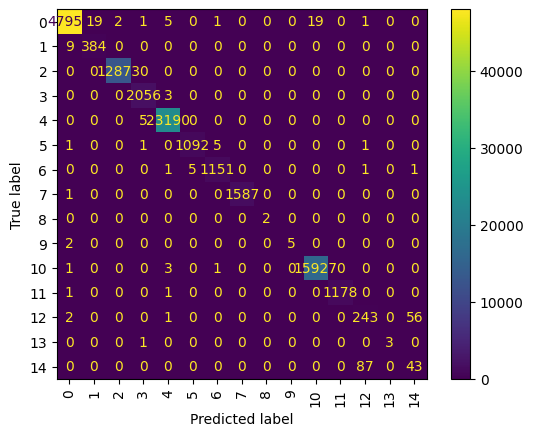

In [34]:
conf_matr = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 8), dpi=120)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matr)
disp = disp.plot()
plt.xticks(rotation=90)
plt.show();

In [35]:
list(label_encoder.inverse_transform([12,13,14]))

['Web Attack � Brute Force', 'Web Attack � Sql Injection', 'Web Attack � XSS']

In [36]:
df_web = df[df['label'].isin([12, 13, 14])].copy()

In [44]:
df_web = df_web.fillna(-1)
df_web.replace([np.inf, -np.inf], 0, inplace=True)
#df_sample[np.isfinite(df_sample) == True] = 0

X_w, y_w = df_web.drop('label', axis=1), df_web['label']
X_wtrain, X_wtest, y_wtrain, y_wtest = train_test_split(
    X_w, y_w, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=df_web['label']
    )

In [45]:
df_web.head()

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,bwd_packet_length_mean,bwd_packet_length_std,flow_bytes/s,flow_packets/s,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_total,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_total,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,bwd_psh_flags,fwd_urg_flags,bwd_urg_flags,fwd_header_length,bwd_header_length,fwd_packets/s,bwd_packets/s,min_packet_length,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,cwe_flag_count,ece_flag_count,down/up_ratio,average_packet_size,avg_fwd_segment_size,avg_bwd_segment_size,fwd_header_length.1,fwd_avg_bytes/bulk,fwd_avg_packets/bulk,fwd_avg_bulk_rate,bwd_avg_bytes/bulk,bwd_avg_packets/bulk,bwd_avg_bulk_rate,subflow_fwd_packets,subflow_fwd_bytes,subflow_bwd_packets,subflow_bwd_bytes,init_win_bytes_forward,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
502002,80,5185118,7,7,1022,2321,372,0,146.00,184.10,1047,0,331.50,439.80,644.73,2.70,398855.22,1372180.80,4963956,4,221162,36860.33,56141.02,141434,4,5185004,864167.30,2027593.40,5001548,879,0,0,0,0,232,232,1.35,1.35,0,1047,222.90,331.20,109775.55,0,0,0,1,0,0,0,0,1,238.80,146.00,331.50,232,0,0,0,0,0,0,7,1022,7,2321,29200,252,3,32,0.00,0.00,0,0,0.00,0.00,0,0,12
502003,80,5057374,10,7,736,9880,395,0,73.60,155.60,4344,0,1411.00,1640.00,2099.11,3.36,316085.88,1239255.10,4963124,36,5057374,561930.44,1650529.20,4963124,192,56185,9364.17,10567.12,21624,36,0,0,0,0,328,232,1.98,1.38,0,4344,590.00,1190.00,1417180.90,0,0,0,1,0,0,0,0,0,624.50,73.60,1411.00,328,0,0,0,0,0,0,10,736,7,9880,29200,243,2,32,0.00,0.00,0,0,0.00,0.00,0,0,12
502004,80,81,1,1,0,0,0,0,0.00,0.00,0,0,0.00,0.00,0.00,24691.36,81.00,0.00,81,81,0,0.00,0.00,0,0,0,0.00,0.00,0,0,0,0,0,0,32,32,12345.68,12345.68,0,0,0.00,0.00,0.00,0,0,0,0,1,1,0,0,1,0.00,0.00,0.00,32,0,0,0,0,0,0,1,0,1,0,270,252,0,32,0.00,0.00,0,0,0.00,0.00,0,0,12
502005,80,5271123,7,5,969,1430,561,0,138.40,240.50,1066,0,286.00,463.80,455.12,2.28,479193.00,1488840.00,4961916,46,5271123,878520.50,2003102.80,4961916,323,270207,67551.75,131604.86,264957,1034,0,0,0,0,232,168,1.33,0.95,0,1066,184.50,330.00,108944.10,0,0,0,1,0,0,0,0,0,199.90,138.40,286.00,232,0,0,0,0,0,0,7,969,5,1430,29200,244,2,32,0.00,0.00,0,0,0.00,0.00,0,0,12
502006,80,5020638,7,4,973,1430,565,0,139.00,241.60,1066,0,357.50,502.50,478.62,2.19,502063.80,1567338.20,4962654,18,5020638,836773.00,2021330.10,4962654,18,18708,6236.00,5195.49,11318,934,0,0,0,0,232,136,1.39,0.80,0,1066,200.20,340.20,115758.20,0,0,0,1,0,0,0,0,0,218.50,139.00,357.50,232,0,0,0,0,0,0,7,973,4,1430,29200,244,2,32,0.00,0.00,0,0,0.00,0.00,0,0,12


In [46]:
pipe_w = Pipeline(
    [
        # ('preprocessor', preprocessor),
        ("regressor", clf)
    ]
)

param_grid_w = [
    {
        'regressor': [CatBoostClassifier(
            random_state=RANDOM_STATE,
            # silent=True,
            loss_function='MultiClass',
            early_stopping_rounds=10,
            verbose=100,
            task_type='GPU',
            cat_features=categorical
        )],
        #  'regressor__iterations': range(50, 400, 50),
        #  'regressor__depth' : range(1, 8, 1),
        #  'regressor__l2_leaf_reg': range(1, 13, 1),
        #  'regressor__learning_rate': np.linspace(0.01, 0.5, 15),
        #  'regressor__auto_class_weights': ['Balanced', 'SqrtBalanced']
    }
]


grid_w = RandomizedSearchCV(pipe_w, param_grid_w, n_iter=30,
                            cv=5, scoring='f1_macro', verbose=3, random_state=RANDOM_STATE)

In [48]:
grid_w.fit(X_wtrain, y_wtrain)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Learning rate set to 0.069467
0:	learn: 1.0428084	total: 19.8ms	remaining: 19.7s
100:	learn: 0.4817273	total: 1.19s	remaining: 10.6s
200:	learn: 0.4249326	total: 2.64s	remaining: 10.5s
300:	learn: 0.3855017	total: 4.23s	remaining: 9.83s
400:	learn: 0.3547475	total: 5.76s	remaining: 8.61s
500:	learn: 0.3265312	total: 7.44s	remaining: 7.41s
600:	learn: 0.3032136	total: 9.11s	remaining: 6.05s
700:	learn: 0.2823171	total: 10.6s	remaining: 4.53s
800:	learn: 0.2636841	total: 12.2s	remaining: 3.02s
900:	learn: 0.2479331	total: 13.6s	remaining: 1.49s
999:	learn: 0.2346929	total: 15.1s	remaining: 0us
[CV 1/5] END regressor=<catboost.core.CatBoostClassifier object at 0x000001601FDAFDC0>;, score=0.738 total time=  15.9s
Learning rate set to 0.069467
0:	learn: 1.0441112	total: 14.2ms	remaining: 14.2s
100:	learn: 0.4826583	total: 1.31s	remaining: 11.6s
200:	learn: 0.4240897	total: 2.85s	remaining: 11.3s
300:	learn: 0.3841939	total: 4.22s	re

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('regressor',
                                              OneVsRestClassifier(estimator=Ridge()))]),
                   n_iter=30,
                   param_distributions=[{'regressor': [<catboost.core.CatBoostClassifier object at 0x000001601FDAFDC0>]}],
                   random_state=42, scoring='f1_macro', verbose=3)

In [49]:
y_wpred = grid_w.predict(X_wtest)
print(classification_report(y_wtest, y_wpred))

              precision    recall  f1-score   support

          12       0.74      0.86      0.80       302
          13       1.00      1.00      1.00         4
          14       0.49      0.32      0.38       130

    accuracy                           0.70       436
   macro avg       0.75      0.73      0.73       436
weighted avg       0.67      0.70      0.68       436



<Figure size 960x960 with 0 Axes>

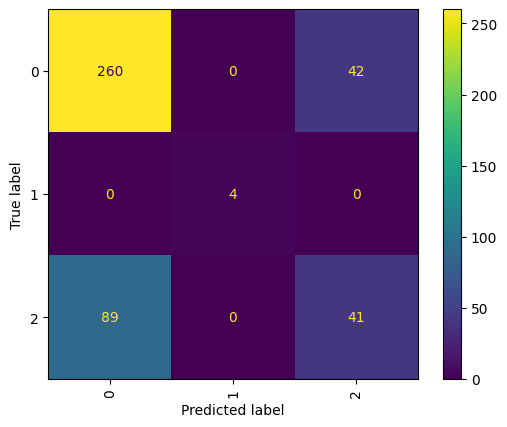

In [53]:
conf_matr_w = confusion_matrix(y_wtest, y_wpred)

plt.figure(figsize=(8, 8), dpi=120)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matr_w)
disp = disp.plot()
plt.xticks(rotation=90)
plt.show();

In [55]:
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [66]:
def test_estimators(X, y, estimators, labels, cv):
    ''' 
    A function for testing multiple estimators.
    It takes: full train data and target, list of estimators, 
              list of labels or names of estimators,
              cross validation splitting strategy;
    And it returns: a DataFrame of table with results of tests
    '''
    result_table = pd.DataFrame()

    row_index = 0
    for est, label in zip(estimators, labels):
        print(label)
        est_name = label
        result_table.loc[row_index, 'Model Name'] = est_name
        
        cv_results = cross_validate(est,
                                    X,
                                    y,
                                    cv = cv,
                                    scoring = 'f1_macro', #'neg_log_loss',
                                    n_jobs = -1)

    #     result_table.loc[row_index, 'Test log loss'] = -cv_results['test_score'].mean()
    #     result_table.loc[row_index, 'Test Std'] = cv_results['test_score'].std()
    #     result_table.loc[row_index, 'Fit Time'] = cv_results['fit_time'].mean()

    #     row_index += 1

    # result_table.sort_values(by = ['Test log loss'], ascending = True, inplace = True)

    cv_results = pd.DataFrame(cv_results)

    return cv_results

In [67]:
logreg = LogisticRegression()
dt = DecisionTreeClassifier(random_state = 1)
rf = RandomForestClassifier()
lgbm = LGBMClassifier()
cb = CatBoostClassifier(logging_level = 'Silent')
svc = SVC(probability = True)
gnb = GaussianNB()

estimators = [logreg,
              dt,
              rf,
              lgbm, 
              cb,
              svc,
              gnb,]

labels = ['LogRegression',
          'DecisionTree',
          'RandomForest',
          'LGBM',
          'CatBoost',
          'SVC',
          'GNB']

results = test_estimators(X_wtrain, y_wtrain, estimators, labels, cv = StratifiedKFold(n_splits = 5))
results.style.background_gradient(cmap = 'Blues')

LogRegression
DecisionTree
RandomForest
LGBM
CatBoost
SVC
GNB


,fit_time,score_time,test_score
0,0.008004,0.003998,0.358793
1,0.009001,0.004005,0.244255
2,0.009003,0.004992,0.347744
3,0.011996,0.005001,0.337162
4,0.008992,0.004000,0.236595


In [ ]:
#%pip freeze > requirements.txt